# Benchmark

In [1]:
import math
import torch
from torch.autograd import Variable
from torch import nn
from torch.nn import functional as F
import pandas as pd
import matplotlib.pyplot as plt

## Generate the dataset

In [2]:
# The following method generates the specified dataset

def sample_generator (dim, center):
    
    # dim -> dimension of the sample
    # center -> center of the radius
    
    # Generate same randomly distributed datapoints in [0,1]^2
    data = torch.empty(dim, 2).uniform_()
    
    # Define radius
    radius = 1 / math.sqrt(2 * math.pi)
    
    # Compute the length of the vector and assign labels
    label = ((data[:,0]-center[0]).pow(2) + (data[:,1]-center[1]).pow(2)).pow(0.5) > radius
    
    # label 0 -> inside the radius
    # label 1 -> outside the radius
    
    # Allocate empty tensor
    target = torch.empty(dim, 2).zero_()
    
    # Assign labels
    for i in range(len(label)):
        if label[i] == 0:
            target[i][0] = 1 # Inside the radius
        else:
            target[i][1] = 1 # Outside the radius
    
    return data, target, label

In [3]:
# Generate training and testing dataset
center = (0.5, 0.5)
train_input, train_target, train_label = sample_generator (1000, center)
test_input, test_target, test_label    = sample_generator (1000, center)

# Convert to variables
train_input, train_target = Variable(train_input), Variable(train_target)
test_input, test_target = Variable(test_input), Variable(test_target)

## Define structure

In [4]:
# Define structure
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        
        self.fc1 = nn.Linear (2, 25)
        self.fc2 = nn.Linear (25, 25)
        self.fc3 = nn.Linear (25, 25)
        self.fc4 = nn.Linear (25, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = torch.tanh(self.fc4(x))
        return x

# Print structure
print(Net())

Net(
  (fc1): Linear(in_features=2, out_features=25, bias=True)
  (fc2): Linear(in_features=25, out_features=25, bias=True)
  (fc3): Linear(in_features=25, out_features=25, bias=True)
  (fc4): Linear(in_features=25, out_features=2, bias=True)
)


## Training

In [5]:
df = pd.DataFrame(data=[], 
                  columns=['Train Loss', 'Train Errors', 'Train Accuracy', 
                           'Test Loss', 'Test Errors', 'Test Accuracy']
                 )

In [6]:
def compute_accuracy (output, target_data):
    
    # Compute number of samples
    nb_samples = float(output.size(0))
    
    # Compute the position of the maximum in the output and target
    pos_output = output.argmax(1)
    pos_target = target_data.argmax(1)
    
    # Compute the number of errors
    nb_error = float(pos_output.ne(pos_target).sum())
    
    # Compute accuracy
    accuracy = 1 - nb_error / nb_samples
    
    return nb_error, accuracy

# Note the "nb_samples" and "nb_error" must be converted to a float because otherwise the output is a tensor

In [7]:
# Training parameters
model         = Net()
epoch         = 2000
criterion     = nn.MSELoss()
learning_rate = 5e-5
optimizer     = torch.optim.SGD(model.parameters(), lr = learning_rate)

In [8]:
for e in range(epoch):
    train_loss = 0
    test_loss  = 0
    
    # Forward propagation
    output = model(train_input)
    
    # Compute loss
    loss = criterion(output, train_target)
    
    # Calculate loss during training
    train_loss = train_loss + loss.item() 
    
    # Initialize gradient
    optimizer.zero_grad()
    
    # Backward propagation
    loss.backward()

    # Optimize
    optimizer.step()
    
    # Compute statistics for training
    train_errors, train_accuracy = compute_accuracy (output, train_target)
    
    # Compute statistics for testing
    test_output = model(test_input)
    loss = criterion(test_output, test_target)
    test_loss = test_loss + float(loss)
    test_errors, test_accuracy = compute_accuracy (test_output, test_target)
    
    # Store results
    df.loc[e] = [train_loss, train_errors, train_accuracy, test_loss, test_errors, test_accuracy]

In [9]:
# Print results at the beginning
display(df.head(5))

,Train Loss,Train Errors,Train Accuracy,Test Loss,Test Errors,Test Accuracy
0,0.580383,499.0,0.501,0.582577,514.0,0.486
1,0.580341,499.0,0.501,0.582535,514.0,0.486
2,0.580298,499.0,0.501,0.582492,514.0,0.486
3,0.580255,499.0,0.501,0.582449,514.0,0.486
4,0.580213,499.0,0.501,0.582407,514.0,0.486


In [10]:
# Print results at the end
display(df.tail(5))

,Train Loss,Train Errors,Train Accuracy,Test Loss,Test Errors,Test Accuracy
1995,0.504274,499.0,0.501,0.506196,514.0,0.486
1996,0.504240,499.0,0.501,0.506162,514.0,0.486
1997,0.504207,499.0,0.501,0.506128,514.0,0.486
1998,0.504173,499.0,0.501,0.506094,514.0,0.486
1999,0.504139,499.0,0.501,0.506060,514.0,0.486


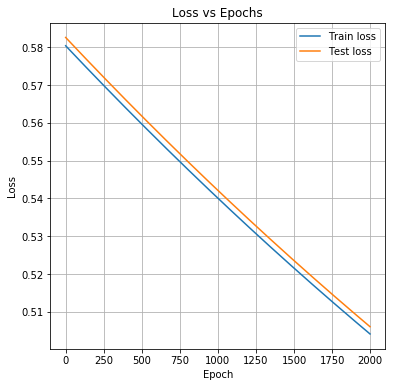

In [11]:
# Show elbow
plt.figure(figsize=(6,6))
plt.plot(df['Train Loss'], label='Train loss')
plt.plot(df['Test Loss'], label='Test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()
plt.grid()
plt.show()

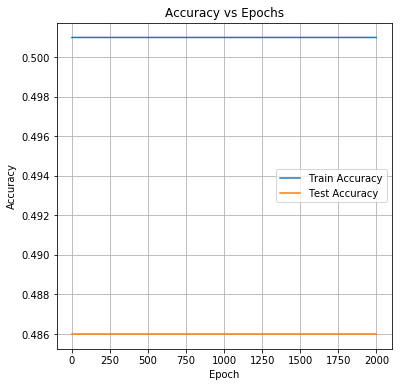

In [12]:
# Show elbow
plt.figure(figsize=(6,6))
plt.plot(df['Train Accuracy'], label='Train Accuracy')
plt.plot(df['Test Accuracy'], label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()
plt.grid()
plt.show()